In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
%load_ext autoreload
%autoreload 2
from modelling import *
from models import * 
from params import * 


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
data_class  = DataClass(use_prediction= True,use_enhanced="fuzzy",custom=False,
                        augmented_data = False)
data_class.create_dataset()
modelling_data = DataModel(data = data_class,
                           use_enhanced= data_class.use_enhanced,
                           custom_test_index=data_class.enhanced_index,
                           max_len=100,
                           custom=False)
modelling_data.create_padding()

modifying features
['link', 'lob', 'employer', 'occupation', 'name_sex', 'firstname_lower']
['link', 'lob', 'employer', 'occupation', 'name_sex', 'firstname_lower_fuzzy']
**************augmenting data set disabled ***********
modifying features
['link', 'lob', 'employer', 'occupation', 'name_sex', 'firstname_lower']
['link', 'lob', 'employer', 'occupation', 'name_sex', 'firstname_lower_fuzzy']
Shape of training tensor:  (155, 100)
Shape of testing tensor:  (77, 100)


In [22]:
%load_ext autoreload 
%autoreload 2
from models import *
model_socface = Model(data = modelling_data,model_name= "bert")
model_socface.fit()
model_socface.predict()
model_socface.compute_results()
model_socface.results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Bert model already fitted, results in bert_models\bert_fuzzy_False.pth


,accuracy_train,accuracy_test,model,custom,missing_names,acc_man,acc_women
0,100,93.506494,bert,0,fuzzy,97.297297,90.0


In [32]:
0.33*232

76.56

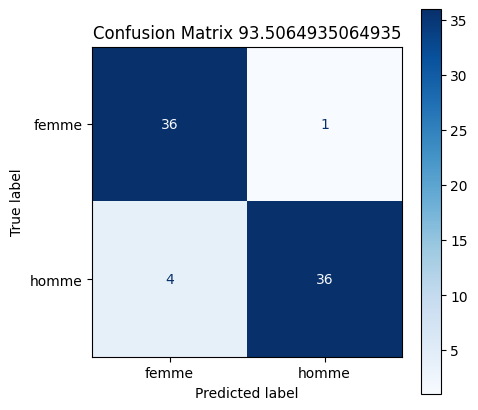

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(model_socface.model.table_results['TRUE'], model_socface.model.table_results['PRED'], labels=[0,1])
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['femme','homme'])
disp.plot(values_format='d', cmap='Blues', ax=ax)
plt.title(f'Confusion Matrix {model_socface.model.accuracy_test}')
plt.show()